In [51]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

#load csv's to dataframes
adv_df = pd.read_csv('advanced_stats.csv')
per_game_df = pd.read_csv('per_game_stats.csv')
stripped_pg_df = per_game_df.drop(columns=['Rk', 'Tm', 'Pos', 'G', 'MP'])
dataframe = adv_df.merge(stripped_pg_df, on = ['Player','Year'], how = 'outer')
dataframe.to_csv('all_stats.csv', index=False)

In [104]:
#create dataset for 2000-2016
dataset = dataframe[(dataframe['Year'] <= 2016) & (dataframe['Year'] >= 2000)& ~(dataframe['Year'] == 2012) & ~(dataframe['Pos'].str.contains('-')) & (dataframe['MP'] > 10)].drop(columns=['Rk','Age▼','Age','Tm','G','MP','Year','TOV','GS','PER']).dropna(axis=1, how='any')
labels = dataset['Pos']
dataset = dataset.drop(columns=['Player','Pos'])
testing_df = dataframe[(dataframe['Year'] == 2017) & (dataframe['MP'] > 10) & ~(dataframe['Pos'].str.contains('-'))].drop(columns=['TS%','3PAr','FTr','Rk','Age▼','Age', 'Tm', 'G', 'MP','Year','TOV%','TOV','FG%', '2P%','eFG%','GS','PER']).dropna(axis=1, how='any')

dataset_past = dataframe[(dataframe['Year'] <= 1998) & (dataframe['Year'] >= 1983) & ~(dataframe['Pos'].str.contains('-')) & (dataframe['MP'] > 10)].drop(columns=['Rk','Age▼','Age','Tm','G','TOV%','MP','Year','TOV','GS','PER']).dropna(axis=1, how='any')
labels_past = dataset_past['Pos']
dataset_past = dataset_past.drop(columns=['Player','Pos'])
testing_df_past = dataframe[(dataframe['Year'] == 1982) & (dataframe['MP'] > 10) & ~(dataframe['Pos'].str.contains('-'))].drop(columns=['TS%','3PAr','FTr','Rk','Age▼','Age', 'Tm', 'G', 'MP','Year','TOV%','FG%', '2P%','eFG%','TOV','GS','PER']).dropna(axis=1, how='any')

#Reasoning: Choose two same-sized time periods (15 yrs) not including 1999 and 2012 seasons (lockout)
#There are other lockout seasons, but only '99 and '12 caused less regular-season games

#remove features that don't vary enough from dataset
scalar = preprocessing.StandardScaler().fit(pd.concat([dataset,dataset_past]))
scaled_train = scalar.transform(dataset)
scaled_test = scalar.transform(testing_df.drop(columns=['Pos','Player']))
test_labels = testing_df['Pos']

pca = PCA(n_components=14).fit(scaled_train_C)
pca_train = pca.transform(scaled_train_C)
pca_test = pca.transform(scaled_test)

#remove features that don't vary enough from past dataset
scaled_train_past = scalar.transform(dataset_past)
scaled_test_past = scalar.transform(testing_df_past.drop(columns=['Pos','Player']))
test_labels_past = testing_df_past['Pos']

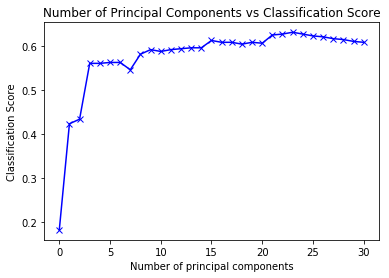

In [105]:
from sklearn.svm import LinearSVC
classifier = LinearSVC(C=5,tol=1e-4,dual=False,penalty='l2')
pca = [PCA(n_components=i).fit(scaled_train) for i in range(1,32)]
pca_train = [pca[i].transform(scaled_train) for i in range(0,31)]
pca_test = [pca[i].transform(scaled_test) for i in range(0,31)]

scores = []
for i in range(0,31):
    classifier.fit(pca_train[i], labels)
    scores.append(classifier.score(pca_test[i], test_labels))

plt.plot(range(0,31), scores, 'bx-')
plt.xlabel('Number of principal components')
plt.ylabel('Classification Score')
plt.title('Number of Principal Components vs Classification Score')
plt.show()

In [106]:
#Optimal linear svc classifier
pca = PCA(n_components=24).fit(scaled_train)
train_modern = pca.transform(scaled_train)
test_modern = pca.transform(scaled_test)
train_past = pca.transform(scaled_train_past)
test_past = pca.transform(scaled_test_past)

classifier_modern = LinearSVC(C=1,tol=1e-4,dual=False,penalty='l2')
classifier_modern.fit(train_modern, labels)

classifier_past = LinearSVC(C=1,tol=1e-4,dual=False,penalty='l2')
classifier_past.fit(train_past, labels_past)

classifier2_modern = LinearSVC(C=1,tol=1e-4,dual=False,penalty='l2')
classifier2_modern.fit(scaled_train, labels)

classifier2_past = LinearSVC(C=1,tol=1e-4,dual=False,penalty='l2')
classifier2_past.fit(scaled_train_past, labels_past)

print("Current players classified by current model correctness: ", 100 * classifier_modern.score(test_modern, test_labels), '%')
print("Past players classified by past model correctness: ", 100 * classifier_past.score(test_past, test_labels_past), '%')
print("\nCurrent players classified by past model correctness: ", 100 * classifier_past.score(test_modern, test_labels), '%')
print("Past players classified by current model correctness: ", 100 * classifier_modern.score(test_past, test_labels_past), '%')
       

Current players classified by current model correctness:  63.33333333333333 %
Past players classified by past model correctness:  64.85623003194888 %

Current players classified by past model correctness:  57.91666666666667 %
Past players classified by current model correctness:  57.50798722044729 %


In [117]:
#prints a nested list [[1,2,3],[4,5,6],...] in a tabular format
def pretty_print_table(tbl):
    s = [[str(e) for e in row] for row in tbl]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
    table = [fmt.format(*row) for row in s]
    print ('\n'.join(table))
    
#returns top 5 items of a nested list (key is index2 - index3) [[1,2,3],[4,5,6],...]
def print_top5(listing):
    top5 = {}
    for stat, modern, past in listing:
        if stat == 'Stat' or stat == "":
            continue
        change = float(modern) - float(past)
        if len(top5) != 5:
            top5[stat] = change
        else:
            min_stat = min(top5.items(), key=lambda x: abs(x[1]))
            if abs(change) > abs(min_stat[1]):
                del top5[min_stat[0]]
                top5[stat] = change
    for k,v in top5.items():
        print('{} : {}'.format(k, v))

    
c = 100*classifier2_modern.coef_
center_weights = c[0]
pforward_weights = c[1]
sforward_weights = c[2]
sguard_weights = c[3]
pguard_weights = c[4]

c2 = 100*classifier2_past.coef_
center_weights2 = c2[0]
pforward_weights2 = c2[1]
sforward_weights2 = c2[2]
sguard_weights2 = c2[3]
pguard_weights2 = c2[4]

center_list = [["Stat", "Modern Importance", "Past Importance"],["","",""]]
pforward_list = [["Stat", "Modern Importance", "Past Importance"],["","",""]]
sforward_list = [["Stat", "Modern Importance", "Past Importance"],["","",""]]
sguard_list = [["Stat", "Modern Importance", "Past Importance"],["","",""]]
pguard_list = [["Stat", "Modern Importance", "Past Importance"],["","",""]]

center_top5_changes = {}
pforward_top5_changes = {}
sforward_top5_changes = {}
sguard_top5_changes = {}
pgaurd_top5_changes = {}

for i in range(0,len(center_weights)):
    center_list.append([str(dataset.columns.values[i]),str(center_weights[i]),str(center_weights2[i])])
for i in range(0,len(pforward_weights)):
    pforward_list.append([str(dataset.columns.values[i]),str(pforward_weights[i]),str(pforward_weights2[i])])
for i in range(0,len(sforward_weights)):
    sforward_list.append([str(dataset.columns.values[i]),str(sforward_weights[i]),str(sforward_weights2[i])])
for i in range(0,len(sguard_weights)):
    sguard_list.append([str(dataset.columns.values[i]),str(sguard_weights[i]),str(sguard_weights2[i])])
for i in range(0,len(pguard_weights)):
    pguard_list.append([str(dataset.columns.values[i]),str(pguard_weights[i]),str(pguard_weights2[i])])
    
print("===Centers==================")
pretty_print_table(center_list)
print("\nMost changed features (Modern - Past):\n")
print_top5(center_list)
print("\n===Power Forwards===========")
pretty_print_table(pforward_list)
print("\nMost changed features (Modern - Past):\n")
print_top5(pforward_list)
print("\n===Small Forwards===========")
pretty_print_table(sforward_list)
print("\nMost changed features (Modern - Past):\n")
print_top5(sforward_list)
print("\n===Shooting Guards==========")
pretty_print_table(sguard_list)
print("\nMost changed features (Modern - Past):\n")
print_top5(sguard_list)
print("\n===Point Guards=============")
pretty_print_table(pguard_list)
print("\nMost changed features (Modern - Past):\n")
print_top5(pguard_list)

===Centers==================
Stat 	Modern Importance  	Past Importance    
     	                   	                   
ORB% 	40.490709032097676 	71.33295575690417  
DRB% 	51.851314764959156 	109.57769145864742 
TRB% 	-61.95212191269716 	-132.7223031283695 
AST% 	-20.789234732245195	-22.041044538494805
STL% 	-2.5622073940753047	-5.6533819485917   
BLK% 	10.086234759501838 	13.128321678617452 
USG% 	4.238243005417747  	-5.87287823770989  
OWS  	23.728196997202406 	-12.114724532181977
DWS  	7.292244022255357  	-6.734277181882228 
WS   	-30.074157154503865	28.615153722376256 
WS/48	5.880344172756727  	-10.72064600173351 
OBPM 	-1.6544794842043817	18.11144822612496  
DBPM 	18.999996060293018 	5.394783066855787  
BPM  	-23.27550608488667 	-8.836584701217342 
VORP 	-3.5915445919382996	-15.072572236432546
FG   	70.83525286469046  	74.4672710770057   
FGA  	-68.480046661498   	-24.663507900656814
3P   	21.563927458395    	95.9521456285978   
3PA  	-69.23479106930462 	-134.75878289266421
2P   

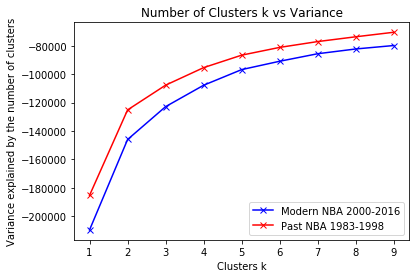

In [88]:
kmeans = [KMeans(n_clusters=i) for i in range(1,10)]
score = [kmeans[i].fit(scaled_train).score(scaled_train_C) for i in range(len(kmeans))]
score_past = [kmeans[i].fit(scaled_train_past).score(scaled_train_past) for i in range(len(kmeans))]
plt.plot(range(1,10),score, 'bx-', label='Modern NBA 2000-2016')
plt.plot(range(1,10),score_past, 'rx-', label='Past NBA 1983-1998')
plt.xlabel('Clusters k')
plt.ylabel('Variance explained by the number of clusters')
plt.title('Number of Clusters k vs Variance')
plt.legend(loc=4)
plt.show()
#Classifying NBA basketball players is a very hard task. 
#Classification score does not abruptly flatline at any value of k
#This implies that the player positions are somewhat loosely defined